Fecha solicitada : 2026-01-23 00:00:00
Fecha usada ERA5 : 2026-01-23 00:00:00


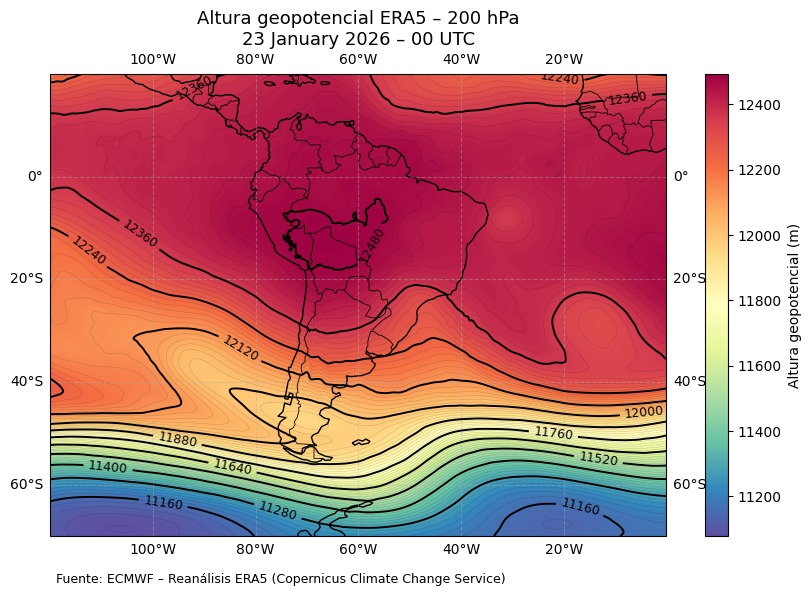

In [6]:
# ------------------------------------------
# MAPAS DE ALTURA GEOPOTENCIAL - ERA5
# FECHA INGRESADA POR EL USUARIO
# ------------------------------------------

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# ------------------------------------------
# ABRIR ARCHIVO
# ------------------------------------------

#ds = xr.open_dataset(r"C:\Users\ANALY AVALOS\Downloads\TRABAJO 2\2026_01.nc")

#fecha = "2026-01-23T00:00:00"


ruta = r"C:\Users\ANALY AVALOS\Downloads\TRABAJO 2\2026_01.nc"
ds = xr.open_dataset(ruta)

# ------------------------------------------
# CORREGIR LONGITUDES (0–360 → -180–180)
# ------------------------------------------
if ds.longitude.max() > 180:
    ds = ds.assign_coords(
        longitude=((ds.longitude + 180) % 360) - 180
    ).sortby("longitude")

# ------------------------------------------
# PEDIR FECHA AL USUARIO
# ------------------------------------------
fecha_input = input("Ingresa la fecha (YYYY-MM-DD HH, en UTC): ")
fecha_usuario = pd.to_datetime(fecha_input)

# Seleccionar el tiempo más cercano disponible
tiempo_real = ds.valid_time.sel(
    valid_time=fecha_usuario,
    method="nearest"
)

print(f"Fecha solicitada : {fecha_usuario}")
print(f"Fecha usada ERA5 : {pd.to_datetime(tiempo_real.values)}")

# ------------------------------------------
# NIVELES A EVALUAR
# ------------------------------------------
niveles = [ 200]

# Intervalos de isoípsas (m)
intervalos = {
    
    200: 120
}

# ------------------------------------------
# LOOP POR NIVEL
# ------------------------------------------
for nivel in niveles:

    # Altura geopotencial en metros
    gph = (
        ds["z"]
        .sel(pressure_level=nivel)
        .sel(valid_time=tiempo_real)
        / 9.80665
    )

    # Recorte espacial
    gph = gph.sel(
        latitude=slice(20, -70),
        longitude=slice(-120, 0)
    )

    # Asegurar matriz 2D
    data = gph.squeeze().values
    lons = gph.longitude.values
    lats = gph.latitude.values
    LON, LAT = np.meshgrid(lons, lats)

    # ------------------------------------------
    # MAPA
    # ------------------------------------------
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        LON, LAT, data,
        cmap="Spectral_r",
        shading="nearest",
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(pcm, ax=ax, label="Altura geopotencial (m)")

    # ==========================================
    # ISOÍPSAS ESTILO MSLP
    # ==========================================

    step_main = intervalos[nivel]     # 120 m
    step_minor = step_main / 6        # 20 m (clave visual)

    # ---------- Isoípsas finitas de fondo ----------
    levels_minor = np.arange(
        np.floor(data.min() / step_minor) * step_minor,
        np.ceil(data.max() / step_minor) * step_minor + step_minor,
        step_minor
    )

    cs_minor = ax.contour(
        LON, LAT, data,
        levels=levels_minor,
        colors="black",
        linewidths=0.25,
        alpha=0.25,
        transform=ccrs.PlateCarree(),
        zorder=2
    )

    # ---------- Isoípsas principales ----------
    levels_main = np.arange(
        np.floor(data.min() / step_main) * step_main,
        np.ceil(data.max() / step_main) * step_main + step_main,
        step_main
    )

    cs_main = ax.contour(
        LON, LAT, data,
        levels=levels_main,
        colors="black",
        linewidths=1.4,
        transform=ccrs.PlateCarree(),
        zorder=3
    )

    ax.clabel(cs_main, fmt="%d", fontsize=9)

   

    # Detalles cartográficos
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.gridlines(draw_labels=True, linestyle="--", alpha=0.4)

    ax.set_extent([-120, 0, -70, 20], crs=ccrs.PlateCarree())

    # ------------------------------------------
    # TÍTULO
    # ------------------------------------------
    ax.set_title(
        f"Altura geopotencial ERA5 – {nivel} hPa\n"
        f"{pd.to_datetime(tiempo_real.values).strftime('%d %B %Y – %H UTC')}",
        fontsize=13
    )

    # ------------------------------------------
    # FUENTE
    # ------------------------------------------
    ax.text(
        0.01, -0.08,
        "Fuente: ECMWF – Reanálisis ERA5 (Copernicus Climate Change Service)",
        transform=ax.transAxes,
        fontsize=9,
        ha="left",
        va="top"
    )

    plt.show()

Fecha solicitada : 2026-01-23 00:00:00
Fecha usada ERA5 : 2026-01-23 00:00:00


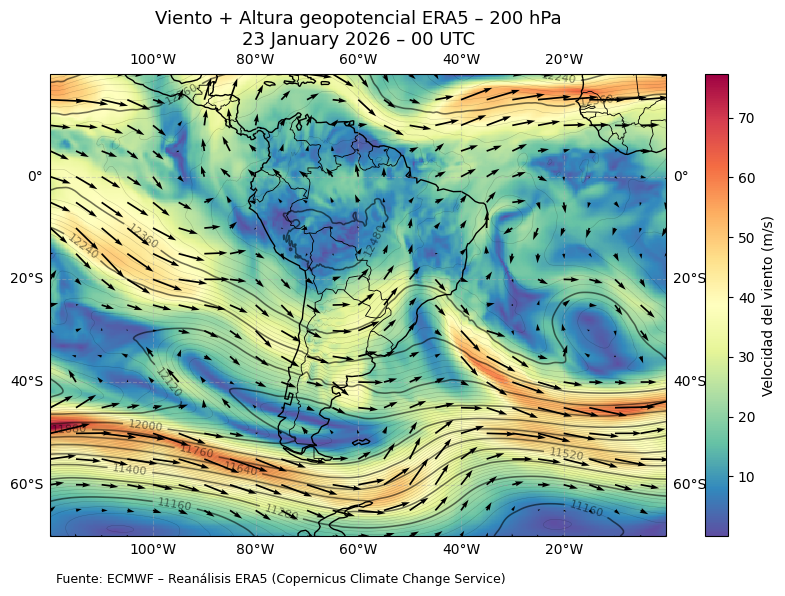

In [38]:
# ------------------------------------------
# MAPA DE VIENTO ERA5
# VELOCIDAD (COLOR) + DIRECCIÓN + ISOÍPSAS GPH
# ------------------------------------------

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# ------------------------------------------
# ABRIR ARCHIVO
# ------------------------------------------
ruta = r"C:\Users\ANALY AVALOS\Downloads\TRABAJO 2\2026_01.nc"
ds = xr.open_dataset(ruta)

# ------------------------------------------
# CORREGIR LONGITUDES (0–360 → -180–180)
# ------------------------------------------
if ds.longitude.max() > 180:
    ds = ds.assign_coords(
        longitude=((ds.longitude + 180) % 360) - 180
    ).sortby("longitude")

# ------------------------------------------
# PEDIR FECHA
# ------------------------------------------
fecha_input = input("Ingresa la fecha (YYYY-MM-DD HH, en UTC): ")
fecha_usuario = pd.to_datetime(fecha_input)

tiempo_real = ds.valid_time.sel(
    valid_time=fecha_usuario,
    method="nearest"
)

print(f"Fecha solicitada : {fecha_usuario}")
print(f"Fecha usada ERA5 : {pd.to_datetime(tiempo_real.values)}")

# ------------------------------------------
# NIVEL
# ------------------------------------------
nivel = 200

# ------------------------------------------
# EXTRAER VIENTO
# ------------------------------------------
u = ds["u"].sel(pressure_level=nivel).sel(valid_time=tiempo_real)
v = ds["v"].sel(pressure_level=nivel).sel(valid_time=tiempo_real)

u = u.sel(latitude=slice(20, -70), longitude=slice(-120, 0))
v = v.sel(latitude=slice(20, -70), longitude=slice(-120, 0))

u = u.squeeze().values
v = v.squeeze().values

# ------------------------------------------
# EXTRAER ALTURA GEOPOTENCIAL
# ------------------------------------------
gph = (
    ds["z"]
    .sel(pressure_level=nivel)
    .sel(valid_time=tiempo_real)
    / 9.80665
)

gph = gph.sel(
    latitude=slice(20, -70),
    longitude=slice(-120, 0)
)

gph_data = gph.squeeze().values

# ------------------------------------------
# COORDENADAS
# ------------------------------------------
lons = ds.longitude.sel(longitude=slice(-120, 0)).values
lats = ds.latitude.sel(latitude=slice(20, -70)).values

LON, LAT = np.meshgrid(lons, lats)

# ------------------------------------------
# VELOCIDAD DEL VIENTO
# ------------------------------------------
wind_speed = np.sqrt(u**2 + v**2)

# ------------------------------------------
# MAPA
# ------------------------------------------
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())

# ------------------------------------------
# FONDO VELOCIDAD
# ------------------------------------------
pcm = ax.pcolormesh(
    LON, LAT, wind_speed,
    cmap="Spectral_r",
    shading="nearest",
    transform=ccrs.PlateCarree(),
    zorder=1
)

plt.colorbar(pcm, ax=ax, label="Velocidad del viento (m/s)")

# ------------------------------------------
# FLECHAS VIENTO
# ------------------------------------------
skip = 20

ax.quiver(
    LON[::skip, ::skip],
    LAT[::skip, ::skip],
    u[::skip, ::skip],
    v[::skip, ::skip],
    scale=900,
    transform=ccrs.PlateCarree(),
    zorder=4
)

# ------------------------------------------
# ISOÍPSAS ALTURA GEOPOTENCIAL
# ------------------------------------------

step_main = 120
step_minor = step_main / 6

# Isoípsas finas (casi transparentes)
levels_minor = np.arange(
    np.floor(gph_data.min()/step_minor)*step_minor,
    np.ceil(gph_data.max()/step_minor)*step_minor + step_minor,
    step_minor
)

ax.contour(
    LON, LAT, gph_data,
    levels=levels_minor,
    colors="black",
    linewidths=0.3,
    alpha=0.25,
    transform=ccrs.PlateCarree(),
    zorder=5
)

# Isoípsas principales
levels_main = np.arange(
    np.floor(gph_data.min()/step_main)*step_main,
    np.ceil(gph_data.max()/step_main)*step_main + step_main,
    step_main
)

cs_main = ax.contour(
    LON, LAT, gph_data,
    levels=levels_main,
    colors="black",
    linewidths=1.2,
    alpha=0.5,
    transform=ccrs.PlateCarree(),
    zorder=7
)

ax.clabel(cs_main, fmt="%d", fontsize=8)

# ------------------------------------------
# DETALLES CARTOGRÁFICOS
# ------------------------------------------
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES, linewidth=0.3)

ax.gridlines(draw_labels=True, linestyle="--", alpha=0.4)

ax.set_extent([-120, 0, -70, 20], crs=ccrs.PlateCarree())

# ------------------------------------------
# TÍTULO
# ------------------------------------------
ax.set_title(
    f"Viento + Altura geopotencial ERA5 – {nivel} hPa\n"
    f"{pd.to_datetime(tiempo_real.values).strftime('%d %B %Y – %H UTC')}",
    fontsize=13
)

# ------------------------------------------
# FUENTE
# ------------------------------------------
ax.text(
    0.01, -0.08,
    "Fuente: ECMWF – Reanálisis ERA5 (Copernicus Climate Change Service)",
    transform=ax.transAxes,
    fontsize=9,
    ha="left",
    va="top"
)

plt.show()


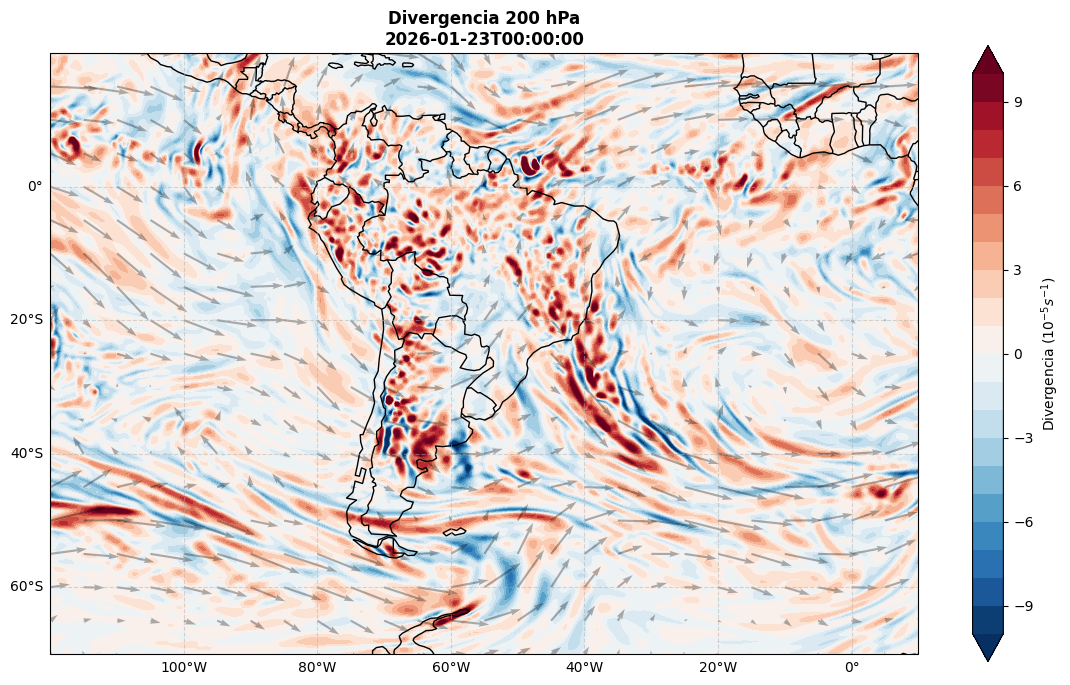

In [43]:
# ------------------------------------------
# MAPA DE DIVERGENCIA CALCULADA DESDE U Y V
# ------------------------------------------

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------------------
# 1. ABRIR ARCHIVO
# ------------------------------------------
ruta = r"C:\Users\ANALY AVALOS\Downloads\TRABAJO 2\2026_01.nc"
ds = xr.open_dataset(ruta)

# ------------------------------------------
# 2. SELECCION NIVEL Y FECHA
# ------------------------------------------
fecha_query = "2026-01-23T00:00:00"

ds_200 = ds.sel(
    pressure_level=200,
    valid_time=fecha_query,
    method="nearest"
)

if "expver" in ds_200.dims:
    ds_200 = ds_200.sel(expver=1).combine_first(ds_200.sel(expver=5))

# ------------------------------------------
# 3. EXTRAER VIENTO
# ------------------------------------------
u = ds_200["u"]
v = ds_200["v"]

lat = ds_200.latitude.values
lon = ds_200.longitude.values


# ------------------------------------------
# 4. CALCULO DIVERGENCIA
# ------------------------------------------
# Convertimos grados → metros
Re = 6371000  # radio tierra m

dlat = np.deg2rad(np.gradient(lat))
dlon = np.deg2rad(np.gradient(lon))

dy = Re * dlat
dx = Re * np.cos(np.deg2rad(lat))[:, None] * dlon

# Gradientes
dudx = np.gradient(u, axis=-1) / dx
dvdy = np.gradient(v, axis=-2) / dy[:, None]

div = dudx + dvdy

# Escalado visual
div_plot = div * 1e5

# ------------------------------------------
# 5. MAPA
# ------------------------------------------
fig, ax = plt.subplots(
    figsize=(14,8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

ax.set_extent([-120, 10, -70, 20], crs=ccrs.PlateCarree())

# Divergencia sombreada
niveles = np.linspace(-10,10,21)

im = ax.contourf(
    lon, lat, div_plot,
    levels=niveles,
    cmap="RdBu_r",
    extend="both",
    transform=ccrs.PlateCarree()
)

# Viento
skip = 20
ax.quiver(
    lon[::skip],
    lat[::skip],
    u[::skip, ::skip],
    v[::skip, ::skip],
    color="black",
    alpha=0.3,
    scale=900,
    transform=ccrs.PlateCarree()
)

# Detalles
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

plt.colorbar(im, label="Divergencia ($10^{-5} s^{-1}$)")

gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
gl.top_labels = False
gl.right_labels = False

ax.set_title(f"Divergencia 200 hPa\n{fecha_query}", fontweight="bold")

plt.show()


Fecha solicitada : 2026-01-23 00:00:00
Fecha usada ERA5 : 2026-01-23 00:00:00


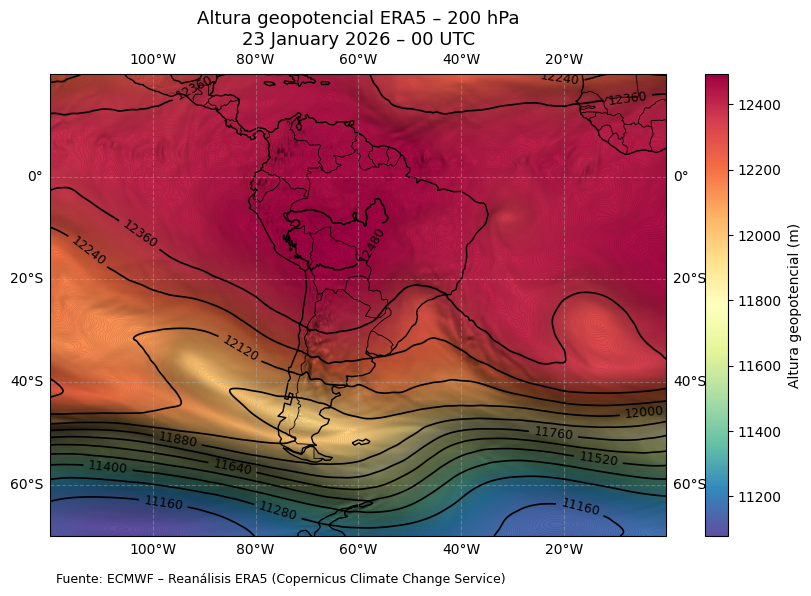

In [13]:
# ------------------------------------------
# MAPAS DE ALTURA GEOPOTENCIAL - ERA5
# FECHA INGRESADA POR EL USUARIO
# ------------------------------------------

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# ------------------------------------------
# ABRIR ARCHIVO
# ------------------------------------------

#ds = xr.open_dataset(r"C:\Users\ANALY AVALOS\Downloads\TRABAJO 2\2026_01.nc")

#fecha = "2026-01-23 00"


ruta = r"C:\Users\ANALY AVALOS\Downloads\TRABAJO 2\2026_01.nc"
ds = xr.open_dataset(ruta)

# ------------------------------------------
# CORREGIR LONGITUDES (0–360 → -180–180)
# ------------------------------------------
if ds.longitude.max() > 180:
    ds = ds.assign_coords(
        longitude=((ds.longitude + 180) % 360) - 180
    ).sortby("longitude")

# ------------------------------------------
# PEDIR FECHA AL USUARIO
# ------------------------------------------
fecha_input = input("Ingresa la fecha (YYYY-MM-DD HH, en UTC): ")
fecha_usuario = pd.to_datetime(fecha_input)

# Seleccionar el tiempo más cercano disponible
tiempo_real = ds.valid_time.sel(
    valid_time=fecha_usuario,
    method="nearest"
)

print(f"Fecha solicitada : {fecha_usuario}")
print(f"Fecha usada ERA5 : {pd.to_datetime(tiempo_real.values)}")

# ------------------------------------------
# NIVELES A EVALUAR
# ------------------------------------------
niveles = [ 200]

# Intervalos de isoípsas (m)
intervalos = {
    
    200: 120
}

# ------------------------------------------
# LOOP POR NIVEL
# ------------------------------------------
for nivel in niveles:

    # Altura geopotencial en metros
    gph = (
        ds["z"]
        .sel(pressure_level=nivel)
        .sel(valid_time=tiempo_real)
        / 9.80665
    )

    # Recorte espacial
    gph = gph.sel(
        latitude=slice(20, -70),
        longitude=slice(-120, 0)
    )

    # Asegurar matriz 2D
    data = gph.squeeze().values
    lons = gph.longitude.values
    lats = gph.latitude.values
    LON, LAT = np.meshgrid(lons, lats)

    # ------------------------------------------
    # MAPA
    # ------------------------------------------
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    pcm = ax.pcolormesh(
        LON, LAT, data,
        cmap="Spectral_r",
        shading="nearest",
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(pcm, ax=ax, label="Altura geopotencial (m)")

    # Isoípsas
    step = intervalos[nivel]
    levels = np.arange(
        np.floor(data.min() / step) * step,
        np.ceil(data.max() / step) * step + step,
        step
    )

    cs_main = ax.contour(
        LON, LAT, data,
        levels=levels,
        colors="black",
        linewidths=1.2,
        transform=ccrs.PlateCarree(),
        zorder=3
    )
    ax.clabel(cs_main, fmt="%d", fontsize=9)

    # ------------------------------------------
    # Isoípsas secundarias (cada 1 m, casi transparentes)
    # ------------------------------------------
    levels_minor = np.arange(
        np.floor(data.min()),
        np.ceil(data.max()),
        1
    )

    cs_minor = ax.contour(
        LON, LAT, data,
        levels=levels_minor,
        colors="black",
        linewidths=0.4,
        alpha=0.15,   # ← controla transparencia (puedes bajar a 0.1 si quieres)
        transform=ccrs.PlateCarree(),
        zorder=2
    )
    ax.clabel(cs, fmt="%d", fontsize=9)

    # Detalles cartográficos
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    ax.gridlines(draw_labels=True, linestyle="--", alpha=0.4)

    ax.set_extent([-120, 0, -70, 20], crs=ccrs.PlateCarree())

    # ------------------------------------------
    # TÍTULO
    # ------------------------------------------
    ax.set_title(
        f"Altura geopotencial ERA5 – {nivel} hPa\n"
        f"{pd.to_datetime(tiempo_real.values).strftime('%d %B %Y – %H UTC')}",
        fontsize=13
    )

    # ------------------------------------------
    # FUENTE
    # ------------------------------------------
    ax.text(
        0.01, -0.08,
        "Fuente: ECMWF – Reanálisis ERA5 (Copernicus Climate Change Service)",
        transform=ax.transAxes,
        fontsize=9,
        ha="left",
        va="top"
    )

    plt.show()
